In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.4
numpy 1.19.5
pandas 1.1.5
sklearn 0.24.2
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
from sklearn import datasets
import tarfile
data_home = datasets.get_data_home()
archive_path = os.path.join(data_home, 'cal_housing.tgz')
with tarfile.open(mode="r:gz", name=archive_path) as f:
     cal_housing = np.loadtxt(
         f.extractfile("CaliforniaHousing/cal_housing.data"), delimiter=","
     )
     # Columns are not in the same order compared to the previous
     # URL resource on lib.stat.cmu.edu
     columns_index = [8, 7, 2, 3, 4, 5, 6, 1, 0]
     cal_housing = cal_housing[:, columns_index]
       
feature_names = [
    "MedInc",
    "HouseAge",
    "AveRooms",
    "AveBedrms",
    "Population",
    "AveOccup",
    "Latitude",
    "Longitude",
]

target, data = cal_housing[:, 0], cal_housing[:, 1:]

# avg rooms = total rooms / households
data[:, 2] /= data[:, 5]

# avg bed rooms = total bed rooms / households
data[:, 3] /= data[:, 5]

# avg occupancy = population / households
data[:, 5] = data[:, 4] / data[:, 5]

# target in units of 100,000
target = target / 100000.0


In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    data,target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [5]:
# RandomizedSearchCV
# 1. 因为是sklearn的接口，转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数

def build_model(hidden_layers = 1,
                layer_size = 30,
                learning_rate = 3e-3):
    model = keras.models.Sequential()
    #因为不知道第一个输入的shape是多大的，因此我们需要单独从for循环里拿出来，for循环里的是输出再次作为输入
    model.add(keras.layers.Dense(layer_size, activation='relu',
                                 input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,
                                     activation = 'relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

#KerasRegressor返回一个sk的model,build_fn是一个回调函数
sklearn_model = tf.keras.wrappers.scikit_learn.KerasRegressor(
    build_fn = build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
#这是对sk封装tf的一个测试
history = sklearn_model.fit(x_train_scaled, y_train,
                            epochs = 10,
                            validation_data = (x_valid_scaled, y_valid),
                            callbacks = callbacks)

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 1.4014 - val_loss: 0.7021
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6028 - val_loss: 0.6069
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5424 - val_loss: 0.5584
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5036 - val_loss: 0.5230
Epoch 5/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4802 - val_loss: 0.5003
Epoch 6/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4630 - val_loss: 0.4863
Epoch 7/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4525 - val_loss: 0.4726
Epoch 8/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4411 - val_loss: 0.4639
Epoch 9/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4346 - val_loss: 0.4541
Epoch 10/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4286 - val_loss: 0.4476

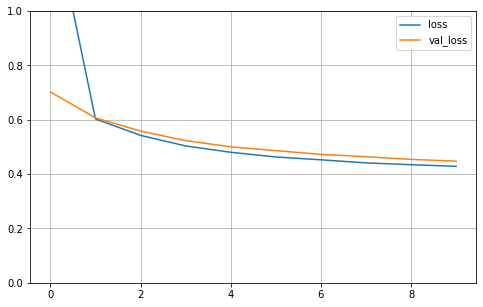

In [6]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [7]:
#scipy也是sk中的
from scipy.stats import reciprocal
# 分布函数
# f(x) = 1/(x*log(b/a)) a <= x <= b

#sk 0.21.3版本可以用这种列表
# param_distribution = {
#     "hidden_layers":[1, 2, 3, 4],
#     "layer_size": np.arange(1, 100),
#     "learning_rate": reciprocal(1e-4, 1e-2),
# }
#最新版本只能用普通列表
param_distribution = {
    "hidden_layers": [1, 2, 3, 4],
    "layer_size": [5, 10, 20, 30],
    "learning_rate": [1e-4, 5e-5, 1e-3, 5e-3, 1e-2],
}

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

#随机搜索
random_search_cv = RandomizedSearchCV(sklearn_model,
                                      param_distribution)
# grid_search_cv =GridSearchCV(sklearn_model,param_distribution)
random_search_cv.fit(x_train_scaled, y_train, epochs = 5,
                     validation_data = (x_valid_scaled, y_valid),
                     callbacks = callbacks)

# grid_search_cv.fit(x_train_scaled, y_train, epochs = 5,
#                      validation_data = (x_valid_scaled, y_valid),
#                      callbacks = callbacks)
# cross_validation: 训练集分成n份，n-1训练，最后一份验证.

Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 8.0655 - val_loss: 7.5730
Epoch 2/5
291/291 [==============================] - 1s 3ms/step - loss: 6.6469 - val_loss: 6.3705
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 5.6694 - val_loss: 5.5153
Epoch 4/5
291/291 [==============================] - 1s 3ms/step - loss: 4.9508 - val_loss: 4.8690
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 4.0078
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 4.2191 - val_loss: 3.9662
Epoch 2/5
291/291 [==============================] - 1s 3ms/step - loss: 3.6114 - val_loss: 3.4187
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 3.1496 - val_loss: 2.9976
Epoch 4/5
291/291 [==============================] - 1s 3ms/step - loss: 2.7919 - val_loss: 2.6744
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 2.3347
Epoch 1/5
291/291 [==============================] -

291/291 [==============================] - 1s 3ms/step - loss: 3.1410 - val_loss: 3.0517
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 2.5074
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 2.1782 - val_loss: 0.8865
Epoch 2/5
291/291 [==============================] - 1s 3ms/step - loss: 0.7556 - val_loss: 0.7754
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 0.6845 - val_loss: 0.7216
Epoch 4/5
291/291 [==============================] - 1s 3ms/step - loss: 0.6448 - val_loss: 0.6840
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 0.5803
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 2.0181 - val_loss: 0.9693
Epoch 2/5
291/291 [==============================] - 1s 3ms/step - loss: 0.7953 - val_loss: 0.7386
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 0.6691 - val_loss: 0.6898
Epoch 4/5
291/291 [==============================] - 1s 3ms/st

291/291 [==============================] - 1s 3ms/step - loss: 1.8853 - val_loss: 0.8521
Epoch 2/5
291/291 [==============================] - 1s 3ms/step - loss: 0.6562 - val_loss: 0.6476
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 0.6846 - val_loss: 0.6092
Epoch 4/5
291/291 [==============================] - 1s 3ms/step - loss: 0.6295 - val_loss: 0.6030
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 0.5572
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 0.9511 - val_loss: 0.6180
Epoch 2/5
291/291 [==============================] - 1s 3ms/step - loss: 0.5336 - val_loss: 0.5019
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 0.4775 - val_loss: 0.4625
Epoch 4/5
291/291 [==============================] - 1s 3ms/step - loss: 0.4435 - val_loss: 0.4430
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 0.3963
Epoch 1/5
291/291 [==============================] - 1s 3ms/st

291/291 [==============================] - 1s 3ms/step - loss: 0.4664 - val_loss: 0.4994
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 0.4610
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 0.8501 - val_loss: 0.5884
Epoch 2/5
291/291 [==============================] - 1s 3ms/step - loss: 0.4944 - val_loss: 0.4958
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 0.4559 - val_loss: 0.4675
Epoch 4/5
291/291 [==============================] - 1s 3ms/step - loss: 0.4280 - val_loss: 0.4452
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 0.4276
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 1.2998 - val_loss: 0.6489
Epoch 2/5
291/291 [==============================] - 1s 3ms/step - loss: 0.5622 - val_loss: 0.5540
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 0.4959 - val_loss: 0.4910
Epoch 4/5
291/291 [==============================] - 1s 3ms/st

RandomizedSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f07454cbf98>,
                   param_distributions={'hidden_layers': [1, 2, 3, 4],
                                        'layer_size': [5, 10, 20, 30],
                                        'learning_rate': [0.0001, 5e-05, 0.001,
                                                          0.005, 0.01]})

In [8]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

# print(grid_search_cv.best_params_)
# print(grid_search_cv.best_score_)
# print(grid_search_cv.best_estimator_)

{'learning_rate': 0.01, 'layer_size': 10, 'hidden_layers': 2}
-0.4227038025856018


In [9]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

# model = grid_search_cv.best_estimator_.model
# model.evaluate(x_test_scaled, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.4183


0.41834187507629395